In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

## System Description
1. We have a set of COFs from a database. Each COF is characterized by a feature vector $$x_{COF} \in X \subset R^d$$ were d=14.


2. We have **two different types** of simulations to calculate **the same material property $S_{Xe/Kr}$**. Therefore, we have a Single-Task/Objective (find the material with the optimal selevtivity), Multi-Fidelity problem. 
    1. low-fidelity  = Henry coefficient calculation - MC integration 
    2. high-fidelity = GCMC mixture simulation - 80:20 (Kr:Xe) at 298 K and 1.0 bar 


3. We will initialize the system with a few COFs at **both** fidelities in order to initialize the Covariance Matrix.
    1. The fist COF will be the one closest to the center of the normalized feature space
    2. The rest will be chosen to maximize diversity of the training set


4. Each surrogate model will **only train on data acquired at its level of fidelity** (Heterotopic data). $$X_{lf} \neq X_{hf} \subset X$$
    1. We could use the augmented EI acquisition function from [here](https://link.springer.com/content/pdf/10.1007/s00158-005-0587-0.pdf)
    2. We could use a naive implementation of the [misoKG](https://papers.nips.cc/paper/2017/file/df1f1d20ee86704251795841e6a9405a-Paper.pdf) acquisition function
    3. Helpful [tutorial](https://botorch.org/tutorials/discrete_multi_fidelity_bo)


5. **kernel model**: 
    1.  We need a Gaussian Process (GP) that will give a *correlated output for each fidelity* i.e. we need a vector-valued kernel
    2. Given the *cost aware* acquisition function, we anticipate the number of training points at each fidelity *will not* be equal (asymmetric scenario) $$n_{lf} > n_{hf}$$

In [2]:
import torch
import gpytorch
from botorch.models import SingleTaskMultiFidelityGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from scipy.stats import norm
from sklearn.decomposition import PCA
import math 
import numpy as np
import matplotlib.pyplot as plt
import pickle
import h5py
import os

# config plot settings
plt.rcParams["font.size"] = 16

In [3]:
###
#  attempting to fix Cholecky jitter error
###
from botorch.optim.fit import fit_gpytorch_torch

In [4]:
###
#  Load Data
###
file = h5py.File("targets_and_normalized_features.jld2", "r")
# feature matrix
X = torch.from_numpy(np.transpose(file["X"][:]))
# simulation data
y = [torch.from_numpy(np.transpose(file["henry_y"][:])), 
     torch.from_numpy(np.transpose(file["gcmc_y"][:]))]
# associated simulation costs
cost = [torch.from_numpy(np.transpose(file["henry_total_elapsed_time"][:])), 
        torch.from_numpy(np.transpose(file["gcmc_elapsed_time"][:]))]

# total number of COFs in data set
nb_COFs = X.shape[0] 

print("raw data - \n\tX:", X.shape)
for f in range(2):
    print("\tfidelity:", f)
    print("\t\ty:", y[f].shape)
    print("\t\tcost: ", cost[f].shape)
    
    
print("\nEnsure features are normalized - ")
print("max:\n", torch.max(X, 0).values)
print("min:\n", torch.min(X, 0).values)

raw data - 
	X: torch.Size([608, 14])
	fidelity: 0
		y: torch.Size([608])
		cost:  torch.Size([608])
	fidelity: 1
		y: torch.Size([608])
		cost:  torch.Size([608])

Ensure features are normalized - 
max:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)
min:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)


In [5]:
print("average high-fidelity cost:", torch.mean(cost[1]).item(), "[min]")
print("average low-fidelity cost: ", torch.mean(cost[0]).item(), "[min]")
print("average cost ratio:\t   ", torch.mean(cost[1] / cost[0]).item())

average high-fidelity cost: 230.0783918372241 [min]
average low-fidelity cost:  16.57287046034216 [min]
average cost ratio:	    13.444745568580501


In [6]:
total_lf_cost = sum(cost[0])
total_lf_cost

tensor(10076.3052, dtype=torch.float64)

In [7]:
total_hf_cost = sum(cost[1])
total_hf_cost

tensor(139887.6622, dtype=torch.float64)

## Helper Functions

#### Construct Initial Inputs

In [8]:
# find COF closest to the center of feature space
def get_initializing_COF(X):
    # center of feature space
    feature_center = np.ones(X.shape[1]) * 0.5
    # max possible distance between normalized features
    return np.argmin(np.linalg.norm(X - feature_center, axis=1))

def diverse_set(X, train_size):
    # initialize with one random point; pick others in a max diverse fashion
    ids_train = [get_initializing_COF(X)]
    # select remaining training points
    for j in range(train_size - 1):
        # for each point in data set, compute its min dist to training set
        dist_to_train_set = np.linalg.norm(X - X[ids_train, None, :], axis=2)
        assert np.shape(dist_to_train_set) == (len(ids_train), nb_COFs)
        min_dist_to_a_training_pt = np.min(dist_to_train_set, axis=0)
        assert np.size(min_dist_to_a_training_pt) == nb_COFs
        
        # acquire point with max(min distance to train set) i.e. Furthest from train set
        ids_train.append(np.argmax(min_dist_to_a_training_pt))
    assert np.size(np.unique(ids_train)) == train_size # must be unique
    return np.array(ids_train)

In [9]:
# construct feature matrix of acquired points
def build_X_train(acquired_set):
    ids_acq = [j[0] for j in acquired_set]
    fid_acq = torch.tensor([j[1] for j in acquired_set])
    return torch.cat((X[ids_acq, :], fid_acq.unsqueeze(dim=-1)), dim=1)

# construct output vector for acquired points
def build_y_train(acquired_set):
    for i, [cof_id, f_id] in enumerate(acquired_set):
        y_t = y[f_id][cof_id].unsqueeze(-1)
        if i == 0:
            y_train = y_t # nitialize
        else:
            y_train = torch.cat((y_train, y_t))
    return y_train.unsqueeze(-1)

# construct vector to track accumulated cost of acquired points
def build_cost(acquired_set):
    for i, [cof_id, f_id] in enumerate(acquired_set):
        c = torch.ones((1, 1), dtype=float) * cost[f_id][cof_id]
        if i == 0:
            costs_acquired = c # initialize
        else:
            costs_acquired = torch.cat((costs_acquired, c))
            
    return costs_acquired

In [10]:
# def test_initializing_functions(X, y):
#     # number of COFs to initialize with at each fidelity
#     nb_COFs_initialization = 3
#     # select COFs to train initial GP
#     initializing_COFs = torch.from_numpy(np.array([1, 3, 4]))
#     # track COFs acquired
#     ids_acquired = torch.from_numpy(np.array([1, 3, 4]))
#     print("Test -\n\tids acquired", ids_acquired)
#     # track the fidelity at which COFs are acquired
#     fidelity_acquired = torch.from_numpy(np.array([1, 0, 0]))
#     print("\tfidelity acquired", fidelity_acquired)
#     # construct training sets
#     X_train = build_X_train(ids_acquired, fidelity_acquired)
#     y_train = build_y_train(ids_acquired, fidelity_acquired)
#     # Test that the constructor functions are working properly
#     assert np.allclose(X[1, :], X_train[0, :14])
#     assert X_train[0, 14] == 1
#     assert X_train[1, 14] == 0
#     assert y_train[0] == y[0]
#     return

# test_initializing_functions(X, y)

#### Surrogate Model

In [11]:
def train_surrogate_model(X_train, y_train):
    model = SingleTaskMultiFidelityGP(
        X_train, 
        y_train, 
        outcome_transform=Standardize(m=1), # m is the output dimension
        data_fidelity=X_train.shape[1] - 1
    )   
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll, optimizer=fit_gpytorch_torch)
    return model

#### Acquisition Function

In [12]:
# calculate posterior mean and variance
def mu_sigma(model, X, fidelity):
    f = torch.tensor((), dtype=torch.float64).new_ones((nb_COFs, 1)) * fidelity
    X_f = torch.cat((X, f), dim=1) # last col is associated fidelity
    f_posterior = model.posterior(X_f)
    return f_posterior.mean.squeeze().detach().numpy(), f_posterior.variance.squeeze().detach().numpy()

# get the current "effective best solution"
def get_y_max(acquired_set, desired_fidelity):
    y_max = 0
    for i, [cof_id, f_id] in enumerate(acquired_set):
        if (f_id == desired_fidelity) & (y[f_id][cof_id].item() > y_max):
            y_max = y[f_id][cof_id].item()
    return y_max

In [13]:
# X_train.size()
# model = train_surrogate_model(X_train, y_train)

# model.covar_module

# model.covar_module.base_kernel.power

# model.covar_module.base_kernel.covar_module_biased.lengthscale = torch.rand(14)

# model.covar_module.base_kernel.covar_module_unbiased.lengthscale

# model.covar_module.base_kernel.covar_module_unbiased.distance_module.parameters

# model.covar_module.base_kernel.covar_module_unbiased.p

# model.covar_module.outputscale

In [14]:
###
# efficient multi-fidelity correlation function
###
def mfbo_correlation_function(model, X, fidelity, acquired_set):
    # given fidelity
    f   = torch.tensor((), dtype=torch.float64).new_ones((nb_COFs, 1)) * fidelity
    X_f = torch.cat((X, f), dim=1) # last col is associated fidelity
    
    #  high-fidelity
    hf   = torch.tensor((), dtype=torch.float64).new_ones((nb_COFs, 1)) 
    X_hf = torch.cat((X, hf), dim=1) # last col is associated fidelity

    # combine into a single tensor
    X_all_fid = torch.cat((X_f, X_hf), dim=0)
    
    # get variance for each fidelity
    var_f = torch.flatten(model.posterior(X_f).variance)
    var_hf = torch.flatten(model.posterior(X_hf).variance) # variance
    
    # posterior covariance 
    cov = torch.diag(model(X_all_fid).covariance_matrix[:X_f.size()[0], X_f.size()[0]:])
    
    corr = cov / (torch.sqrt(var_f) * torch.sqrt(var_hf))
    return corr

In [15]:
#####################################################################

In [16]:
###
#  Multi-fideltiy correlation 
#  corr[] = k - k_1K^{-1}k_0
###
def multi_fidelity_correlation(model, X, fidelity, acquired_set):
    # get covariance matrix of acquired data points
    sigma_yy  = model.covar_module(X_train).evaluate() 
    sigma_yy_inv = torch.inverse(sigma_yy) # take the inverse

    # get posterior for fidelity f
    f   = torch.tensor((), dtype=torch.float64).new_ones((nb_COFs, 1)) * fidelity
    X_f = torch.cat((X, f), dim=1) # last col is associated fidelity
    var_f = torch.flatten(model.posterior(X_f).variance)

    # get posterior for high-fidelity
    hf = torch.tensor((), dtype=torch.float64).new_ones((nb_COFs, 1)) 
    X_hf = torch.cat((X, hf), dim=1) # last col is associated fidelity
    var_hf = torch.flatten(model.posterior(X_hf).variance)

    # Compute the covariance between X_hf and X_f, using covariance kernel
    sigma_xx = model.covar_module.forward(X_hf, X_f, diag=True) # want diag

    # Compute the covariance between X_f and X_train 
    # rows are [k(x,s), (x_1, s_1), ..., k((x, s), (x_N, s_N))]
    cov_f_and_data = model.covar_module.forward(X_f, X_train).evaluate()

    # Compute the covariance between X_hf and X_train
    # rows are [k(x,s'), (x_1, s_1), ..., k((x, s'), (x_N, s_N))]
    cov_hf_and_data = model.covar_module.forward(X_hf, X_train).evaluate()

    # perform matrix multiplication: k_f * K_inv * k_hf
    sigma_reduction = torch.matmul(torch.matmul(cov_f_and_data, sigma_yy_inv), 
                       torch.t(cov_hf_and_data)).diag()
    # calculate covariance
    posterior_cov = sigma_xx - sigma_reduction
    # calculate the correlation
    corr = posterior_cov / (torch.sqrt(var_f) * torch.sqrt(var_hf))
    return corr

In [17]:
##########################################################################################

In [18]:
###
#  Cost ratio
###
def cost_ratio(fidelity, acquired_set, costs_acquired):
    # get fidelities from acquired set
    f_acq = torch.tensor([acq_[1].item() for acq_ in acquired_set])
    
    avg_cost_f  = torch.mean(costs_acquired[f_acq == fidelity]).item()
    avg_cost_hf = torch.mean(costs_acquired[f_acq == 1]).item()
    return avg_cost_hf / avg_cost_f

###
#  Expected Imrovement function, only uses hf
###
def EI_hf(model, X, acquired_set):
    hf_mu, hf_sigma = mu_sigma(model, X, 1)
    y_max = get_y_max(acquired_set, 1)
    
    z = (hf_mu - y_max) / hf_sigma
    explore_term = hf_sigma * norm.pdf(z) 
    exploit_term = (hf_mu - y_max) * norm.cdf(z) 
    ei = explore_term + exploit_term
    return np.maximum(ei, np.zeros(nb_COFs))

###
#  Acquisition function
###
def acquisition(model, X, fidelity, acquired_set, costs_acquired):
    # expected improvement for high-fidelity
    ei = EI_hf(model, X, acquired_set) 
    
    # augmenting functions
#     a1 = multi_fidelity_correlation(model, X, fidelity, acquired_set)
    a1 = mfbo_correlation_function(model, X, fidelity, acquired_set)
    
    a2 = 1.0 # no systematic random error noise 
    a3 = cost_ratio(fidelity, acquired_set, costs_acquired)

    acquisition_values = torch.from_numpy(ei) * a1 * a2 * a3
    return acquisition_values

# Run MFBO

In [19]:
def construct_initial_inputs(X, y, nb_COFs_initialization, discrete_fidelities):
    initializing_COFs = diverse_set(X, nb_COFs_initialization)
    init_flag = True 
    for i, cof_id in enumerate(initializing_COFs):
        for j ,f_id in enumerate(discrete_fidelities):
            acq_ = torch.tensor([[cof_id, f_id]], dtype=int)
            if i == 0 and j == 0:
                acquired_set = acq_ # initialize
            else:
                acquired_set = torch.cat((acquired_set, acq_))
            
    costs_acquired = build_cost(acquired_set)
    return acquired_set, costs_acquired

In [20]:
###
#  construct initial inputs
###
discrete_fidelities = [0, 1] # set of discrete fidelities to select from
nb_COFs_initialization = 3   # at each fidelity, number of COFs to initialize with
nb_iterations = 100          # BO budget, includes initializing COFs

acquired_set, costs_acquired = construct_initial_inputs(X, y, nb_COFs_initialization, discrete_fidelities)

X_train = build_X_train(acquired_set)
y_train = build_y_train(acquired_set)

print("Initialization - \n")
print("\tid acquired = ", [acq_[0].item() for acq_ in acquired_set])
print("\tfidelity acquired = ", [acq_[1].item() for acq_ in acquired_set])
print("\tcosts acquired = ", costs_acquired.squeeze().detach().numpy(), " [min]")

print("\n\tTraining data:\n")
print("\t\t X train shape = ", X_train.shape)
print("\t\t y train shape = ", y_train.shape)
print("\t\t training feature vector = \n", X_train[0])

Initialization - 

	id acquired =  [25, 25, 494, 494, 523, 523]
	fidelity acquired =  [0, 1, 0, 1, 0, 1]
	costs acquired =  [ 33.25071268 399.7576661   33.2388743  171.99848711   6.12068812
 280.45236813]  [min]

	Training data:

		 X train shape =  torch.Size([6, 15])
		 y train shape =  torch.Size([6, 1])
		 training feature vector = 
 tensor([0.1500, 0.4533, 0.1088, 0.5523, 0.4387, 0.1463, 0.3480, 0.2643, 0.0000,
        0.1769, 0.2237, 0.0000, 0.0000, 0.3471, 0.0000], dtype=torch.float64)


In [21]:
# ###
# #  Comparison TEST of Correlation functions
# ###

# model = train_surrogate_model(X_train, y_train)

# fidelity = 0

# # given fidelity
# f   = torch.tensor((), dtype=torch.float64).new_ones((nb_COFs, 1)) * fidelity
# X_f = torch.cat((X, f), dim=1) # last col is associated fidelity

# #  high-fidelity
# hf = torch.tensor((), dtype=torch.float64).new_ones((nb_COFs, 1)) 
# X_hf = torch.cat((X, hf), dim=1) # last col is associated fidelity

# # c
# X_all_fid = torch.cat((X_f, X_hf), dim=0)

# # calling model.forward() returns the prior 
# # prior = torch.diag(model.forward(X_all_fid).covariance_matrix[:X_f.size()[0], X_f.size()[0]:])

# # calling model._call_() returns the posterior
# # posterior = torch.diag(model(X_all_fid).covariance_matrix[:X_f.size()[0], X_f.size()[0]:])

# # call old correlation function
# c1 = multi_fidelity_correlation(model, X, fidelity, acquired_set)

# # call new correlation function
# c2 = mfbo_correlation_function(model, X, fidelity, acquired_set)

# [np.isclose(c1[i].item(), c2[i].item()) for i in range(c1.size()[0])]

In [22]:
###
#  Run Search
###
for i in range(nb_COFs_initialization * len(discrete_fidelities), nb_iterations + 1):
    ###
    #  Train Model
    ###
    model = train_surrogate_model(X_train, y_train)

    ###
    #  Evaluate Acquisition Function
    ###
    ids_acquired = torch.tensor([acq_[0].item() for acq_ in acquired_set])
#     ids_acquired = torch.tensor(list(zip(*acquired_set))[0])

    acquisition_values = []
    f_id_acq    = -1 # dummy val we know will be overwritten
    cof_id_acq  = -1
    max_acq_val = 0
    for fidelity in discrete_fidelities:
        # evaluate acquisition function at given fidelity
        f_acquisition_values = acquisition(model, X, fidelity, acquired_set, costs_acquired)
        # sort in descending order
        f_acquisition_sorted = f_acquisition_values.argsort(descending=True)
        ### Strategy here: ####
        #  1. loop through sorted indexes 
        #  2. check that the COF is in the list of acquired values with the given fidelity.
        #     a) If the cof_id isn't in the acquired_set, then we don't need to check the fidelity
        #     b) If it is in the acquired_set, then we have to check at which fidelity it was acquired
        #  3. check if the acquisition value for the proposed cof_id at this fidelity is higher 
        #     than the highest acquisition values for the other ids and fidelities checked so far
        #     a) if TRUE, store it -> becomes our new highest acquisition value to check against
        #  4. once we've gone through all discrete fidelity levels, 
        #     we acquire the (cof_id, f_id) pair which had the highest value
        ###
        for sorted_id in f_acquisition_sorted:
            if len(np.where(ids_acquired == sorted_id)[0]) == 0:
                # this cof_id is not in the current acquired_set
                f_id_max_aquisition = sorted_id.item()
                break
            elif (0 < len(np.where(ids_acquired == sorted_id)[0]) and 
                  len(np.where(ids_acquired == sorted_id)[0]) < len(discrete_fidelities)):
                # check if this cof_id has already been sampled at both fidelities
                if acquired_set[np.where(ids_acquired == sorted_id)[0].item()][1] != fidelity:
                    # if the fidelity acquired for this COF is not the fidelity we are proposing, 
                    # store cof_id comparison (allow potential acquisition at proposed fidelity)
                    f_id_max_aquisition = sorted_id.item()
                    break
        # check if proposed acquisition is the max across evaluated fidelities
        if f_acquisition_values[f_id_max_aquisition] > max_acq_val:
            # update max acquisition value
            max_acq_val = f_acquisition_values[f_id_max_aquisition]
            # update cof_id of max acquisition value
            cof_id_acq  = f_id_max_aquisition
            # update f_id of max acquisition value
            f_id_acq = fidelity
    ###
    #  Updates
    ###
    # Update acquired_set
    acq_ = torch.tensor([[cof_id_acq, f_id_acq]], dtype=int)
    acquired_set = torch.cat((acquired_set, acq_))

    # Update training sets and cost
    X_train = build_X_train(acquired_set)
    y_train = build_y_train(acquired_set)
    costs_acquired = build_cost(acquired_set)

Iter 10/100: 8.649342013940094
Iter 20/100: 6.261137550553084
Iter 30/100: 4.990258879375678
Iter 40/100: 4.189199617403134
Iter 50/100: 3.9705665875735296
Iter 60/100: 3.861769073961766
Iter 70/100: 3.8169358792521293
Iter 80/100: 3.795750757562434
Iter 90/100: 3.7861843682757677
Iter 100/100: 3.7794894791133067
Iter 10/100: 7.646945835678672
Iter 20/100: 5.585887635634202
Iter 30/100: 4.477827559087131
Iter 40/100: 3.7812309804197684
Iter 50/100: 3.594931828310967
Iter 60/100: 3.505939425908695
Iter 70/100: 3.467344259644532
Iter 80/100: 3.449124945154929
Iter 90/100: 3.440125417338264
Iter 100/100: 3.433559934208628
Iter 10/100: 6.899188107904619
Iter 20/100: 5.0859008568795225
Iter 30/100: 4.110207791298418
Iter 40/100: 3.510394913486166
Iter 50/100: 3.338797727939354
Iter 60/100: 3.2593365749530165
Iter 70/100: 3.225232648462293
Iter 80/100: 3.209389231525344
Iter 90/100: 3.2016902440879482
Iter 100/100: 3.1962046505342934
Iter 10/100: 6.293461790718118
Iter 20/100: 4.672706263158

Iter 50/100: 1.7897560472251892
Iter 60/100: 1.7341749226969698
Iter 10/100: 2.6351001616517484
Iter 20/100: 2.1930641003752513
Iter 30/100: 1.9624464688665637
Iter 40/100: 1.852833792992028
Iter 50/100: 1.775338091328095
Iter 60/100: 1.7230033295635667
Iter 70/100: 1.704723657170295
Iter 10/100: 2.6050576718970744
Iter 20/100: 2.171835460415102
Iter 30/100: 1.9443009853598003
Iter 40/100: 1.8355030307388567
Iter 50/100: 1.7577579047441774
Iter 60/100: 1.7158409984276832
Iter 10/100: 2.577057617685498
Iter 20/100: 2.1521814819373506
Iter 30/100: 1.927932570395605
Iter 40/100: 1.82044753563224
Iter 50/100: 1.7427805720783627
Iter 60/100: 1.6908210532152093
Iter 70/100: 1.6794558371419857
Iter 10/100: 2.551723852237166
Iter 20/100: 2.13473284910012
Iter 30/100: 1.9142696341029926
Iter 40/100: 1.8087536193827514
Iter 50/100: 1.7318583932274199
Iter 60/100: 1.6788105553409296
Iter 70/100: 1.6662347090397773
Iter 80/100: 1.6601535278635282
Iter 90/100: 1.6585744803686406
Iter 100/100: 1.657

Iter 50/100: 1.3219201905805935
Iter 60/100: 1.3219586413509656
Iter 70/100: 1.2748965259262994
Iter 80/100: 1.2708928380389217
Iter 90/100: 1.2679801990675619
Iter 100/100: 1.2667383979632647
Iter 10/100: 1.995836224131154
Iter 20/100: 1.7264722824295384
Iter 30/100: 1.5365854903406422
Iter 40/100: 1.4174627714109953
Iter 50/100: 1.3377010582713267
Iter 60/100: 1.3165585438104423
Iter 70/100: 1.2698348916388436
Iter 80/100: 1.2661178491469696
Iter 90/100: 1.2641662439010453
Iter 100/100: 1.263645857361611
Iter 10/100: 1.9884401587638536
Iter 20/100: 1.7211614622521452
Iter 30/100: 1.531619493502006
Iter 40/100: 1.4105770221274212
Iter 50/100: 1.331253018885275
Iter 60/100: 1.2916301350131276
Iter 70/100: 1.2648471209393315
Iter 80/100: 1.2612123249977962
Iter 90/100: 1.2592495204065137
Iter 100/100: 1.2588501176649012
Iter 10/100: 1.9819266601102956
Iter 20/100: 1.7166469260451889
Iter 30/100: 1.5276857808862256
Iter 40/100: 1.4046259072039722
Iter 50/100: 1.3248513875512147
Iter 60/1

In [23]:
###
# look at unique COFs acquired
###
ids_acquired = torch.tensor([acq_[0].item() for acq_ in acquired_set])
unique_ids = len(np.unique(ids_acquired))
print("total number of unique COfs sampled")

###
#  Iterations until top COF and accumulated 
###
top_cof = np.argmax(ids_acquired == np.argmax(y[1]))
top_cof_acc_cost = sum(costs_acquired[:top_cof]).item() 

print("iteration we acquire top COF = ", top_cof.item() + 1)
print("accumulated cost up to observation of top COF = ", top_cof_acc_cost, " [min]" )

total number of unique COfs sampled
iteration we acquire top COF =  51
accumulated cost up to observation of top COF =  1493.3083884596824  [min]


# Store Results

In [24]:
mfbo_res = dict({'acquired_set': acquired_set,
                 'costs_acquired': costs_acquired
                })

with open('mfbo_results_with_EI.pkl', 'wb') as file:
    pickle.dump(mfbo_res, file)

## PLOTS

In [25]:
fids_acquired = torch.tensor([acq_[1].item() for acq_ in acquired_set])

In [26]:
max_selectivity  = np.zeros(len(ids_acquired), dtype=float)
selectivity_acquired = np.zeros(len(ids_acquired), dtype=float)
net_cost  = np.zeros(len(ids_acquired), dtype=float)

hl = 2 * nb_COFs_initialization
y_max = 0

for i in range(len(ids_acquired)):
    net_cost[i] = sum(costs_acquired[:i])
    if fids_acquired[i] == 1:
        selectivity_acquired[i] = y[1][ids_acquired[i]]
        if selectivity_acquired[i] > y_max:
            y_max = selectivity_acquired[i]
        max_selectivity[i] = y_max
    else:
        max_selectivity[i] = y_max
        selectivity_acquired[i] = y[0][ids_acquired[i]]

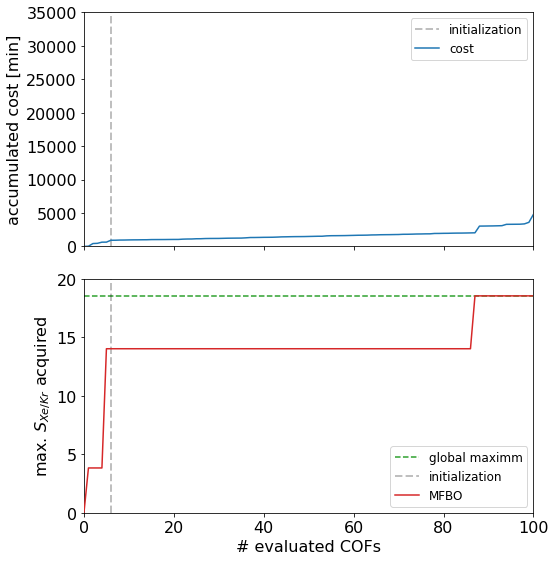

In [27]:
plt.figure(figsize=(8, 8))

ax1 = plt.subplot(2, 1, 1)
plt.axvline(x=hl, label="initialization", color="k", alpha=0.25, linestyle="--", lw=2)
plt.plot(range(len(ids_acquired)), net_cost, label="cost", color="tab:blue")
plt.legend(fontsize=12)
plt.ylabel("accumulated cost [min]")
plt.xlim(xmin=0, xmax=nb_iterations)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylim(ymin=0, ymax=35000) #

plt.subplot(2, 1, 2, sharex=ax1)
plt.axhline(y=max(y[1]), label="global maximm", color="tab:green", ls="--", lw=1.5)
plt.axvline(x=hl, label="initialization", color="k", alpha=0.25, linestyle="--", lw=2)
plt.plot(range(len(ids_acquired)), max_selectivity, label="MFBO", color="tab:red", zorder=3)
plt.ylim(ymin=0, ymax=20)
plt.xlabel("# evaluated COFs")
plt.ylabel("max. $S_{Xe/Kr}$ acquired")

plt.legend(fontsize=12)

plt.tight_layout()
# plt.savefig("figs/mfbo/multi_fidelity_bo_search_efficientcy_curve.png", dpi=600, format="png")
# plt.savefig("figs/mfbo/multi_fidelity_bo_search_efficientcy_curve.pdf", dpi=600, format="pdf")
plt.show()